### Referenes
* https://docs.pymc.io/notebooks/GP-MaunaLoa.html
* https://www.cs.toronto.edu/~duvenaud/thesis.pdf
* https://docs.pymc.io/notebooks/GP-MeansAndCovs.html

In [902]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano.tensor as tt

from bokeh.plotting import figure, show, output_file
from bokeh.models import BoxAnnotation, Span, Label, Legend
from bokeh.io import output_notebook
from bokeh.palettes import brewer
from IPython.display import IFrame

import matplotlib.pyplot as plt
%matplotlib inline

output_notebook()

Loading BokehJS ...

In [879]:
def seasonal(t, s, c, period):
    sea = s[0] * np.sin((1*np.pi)*t/period) + s[1] * np.sin((2*np.pi)*t/period) + s[2] * np.sin((3*np.pi)*t/period) + c[0] * np.cos((1*np.pi)*t/period) + c[1] * np.cos((2*np.pi)*t/period) + c[2] * np.cos((3*np.pi)*t/period) 
    return sea

def drift(N,sig):
    steps = np.random.normal(loc=0, scale=sig, size=N) #std =5.304
    return np.cumsum(steps)

def dates_to_idx(timelist, ref_date):
    reference_time = pd.to_datetime(ref_date)
    t = (timelist - reference_time) / np.timedelta64(1, 'Y')
    return np.asarray(t)

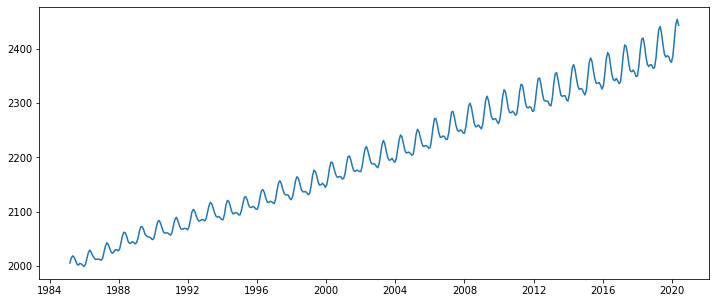

In [880]:
N = 400

t = np.array(range(N))
t = dates_to_idx(dates, '3/01/1985')
N = len(t)
s = seasonal(t, [10,5,0.2], [5,-0.5,0.4], 0.5)
y = 2000 + 12*t + s*np.exp(0.03*t) + drift(N,1) 

plt.figure(figsize=(12,5))
plt.plot(dates, y);

y_std = np.std(y)
y_first = y[0]
y = (y - y_first)/y_std

t = t.reshape(-1,1)

In [881]:
N_back = 50 
t_before = t[:-N_back]
y_before = y[:-N_back]

with pm.Model() as model:
    
    period  = pm.Normal("period", mu=0.5, sigma=0.05)
    #period  = pm.Normal("period", mu=12, sigma=0.5)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=0.2, beta=0.15)
    
    ls_per = pm.HalfNormal("alpha_per", sigma=0.1)
    alpha_per = pm.HalfNormal("ls_per", sigma=0.2)
    tau_per = pm.HalfNormal("tau_per", sigma=2)
    cov_se = tau_per * pm.gp.cov.RatQuad(1, ls_per, alpha_per) 
    
    lin_b_per = pm.HalfNormal("lin_b_per", sigma=0.5)
    lin_c_per = pm.HalfNormal("lin_c_per", sigma=1)
    lin_tau_per = pm.HalfNormal("lin_tau_per", sigma=1)
    cov_linear_per = lin_b_per + lin_tau_per * pm.gp.cov.Linear(1, lin_c_per)
    
    cov_seasonal = pm.gp.cov.Periodic(1, period, ℓ_psmooth) * cov_se * cov_linear_per   
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)
    
    # small/medium term irregularities
    η_med = pm.HalfCauchy("η_med", beta=0.5, testval=0.1)
    ℓ_med = pm.Gamma("ℓ_med", alpha=2, beta=0.75)
    α = pm.Gamma("α", alpha=5, beta=2)
    
    cov_medium = η_med**2 * pm.gp.cov.RatQuad(1, ℓ_med, α)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)
 
    c = pm.HalfNormal("c", sigma=1)
    tau = pm.HalfNormal("tau", sigma=1)
    b = pm.HalfNormal("b", sigma=2)
    cov_linear = b + tau * pm.gp.cov.Linear(1, c)

    cov_trend = cov_linear    
    gp_trend = pm.gp.Marginal(cov_func=cov_linear)

   # noise model
    σ  = pm.HalfNormal("σ",  sigma=0.25, testval=0.05)
    cov_noise = cov_linear * pm.gp.cov.WhiteNoise(σ)
    
    # The Gaussian process is a sum of these three components
    gp = gp_medium + gp_trend + gp_seasonal

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=t_before, y=y_before, noise=cov_noise)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)

/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [882]:
# predict at a 15 day granularity
tnew = t
#dates = t.flatten()

print("Predicting with gp ...")
mu, var = gp.predict(tnew, point=mp, diag=True)
mean_pred = mu*y_std + y_first
var_pred  = var*y_std**2

# make dataframe to store fit results
fit = pd.DataFrame({"t": tnew.flatten(), "mu_total": mean_pred, "sd_total": np.sqrt(var_pred)}, index=dates)

print("Predicting with gp_trend ...")
mu, var = gp_trend.predict(tnew, point=mp, given={"gp": gp, "X": t, "y": y, "noise": cov_noise}, diag=True)
fit = fit.assign(mu_trend = mu*y_std + y_first, sd_trend = np.sqrt(var*y_std**2))

print("Predicting with gp_medium ...")
mu, var = gp_medium.predict(tnew, point=mp, given={"gp": gp, "X": t, "y": y, "noise": cov_noise}, diag=True)
fit = fit.assign(mu_medium = mu*y_std + y_first, sd_medium = np.sqrt(var*y_std**2))

print("Predicting with gp_seasonal ...")
mu, var = gp_seasonal.predict(tnew, point=mp, given={"gp": gp, "X": t, "y": y, "noise": cov_noise}, diag=True)
fit = fit.assign(mu_seasonal = mu*y_std + y_first, sd_seasonal = np.sqrt(var*y_std**2))
print("Done")

Predicting with gp ...
Predicting with gp_trend ...
Predicting with gp_medium ...
Predicting with gp_seasonal ...
Done


In [914]:
## plot the components
p = figure(title="Decomposition of Monthly Hospital Visits", x_axis_type='datetime', plot_width=750, plot_height=500)
p.yaxis.axis_label = 'Monthly Visits'
p.xaxis.axis_label = 'Date'

# plot mean and 2σ region of total prediction
upper = fit.mu_total + 2*fit.sd_total
lower = fit.mu_total - 2*fit.sd_total
band_x = np.append(dates.values, dates.values[::-1])
band_y = np.append(lower, upper[::-1])

# total fit
p.line(dates, fit.mu_total, line_width=1, line_color="firebrick", legend_label="Total fit")
p.patch(band_x, band_y, color="firebrick", alpha=0.6, line_color="white")

# trend
p.line(dates, fit.mu_trend, line_width=1, line_color="blue", legend_label="Long term trend")

# medium
p.line(dates, fit.mu_medium, line_width=1, line_color="green", legend_label="Medium range variation")

# seasonal
p.line(dates, fit.mu_seasonal, line_width=1, line_color="orange", legend_label="Seasonal process")

# true value
p.circle(dates, y * y_std + y_first, color="black", legend_label="Observed data", size=2)
p.legend.location = "top_left"

#show(p)
output_file('decomposition.html')

IFrame(src='./decomposition.html', width=780, height=550)

In [884]:
print("Sampling gp predictions ...")
t_before = t[:-N_back]
mu_est, cov_est = gp.predict(t_before, point=mp)

dates_later = pd.date_range(start='07/09/2006', end="06/01/2028", freq="30D")
tnew = dates_to_idx(dates_later, '3/01/1985').reshape(-1,1)
mu_pred, cov_pred = gp.predict(tnew, point=mp)

n_samples = 2000
samples = pm.MvNormal.dist(mu=mu_pred, cov=cov_pred).random(size=n_samples)
samples = samples * y_std + y_first

mu_est_sc = mu_est * y_std + y_first
sd_est_sc = np.sqrt(np.diag(cov_est) * y_std**2)
upper_est = mu_est_sc + 2*sd_est_sc
lower_est = mu_est_sc - 2*sd_est_sc

mu_pred_sc = mu_pred * y_std + y_first
sd_pred_sc = np.sqrt(np.diag(cov_pred) * y_std**2)

upper_pred = mu_pred_sc + 2*sd_pred_sc
lower_pred = mu_pred_sc - 2*sd_pred_sc

y_orig = y * y_std + y_first

t_before = t_before.flatten()
t_later = tnew.flatten()

Sampling gp predictions ...


In [915]:
### make plot
p = figure(title="Monthly Visits: Projections (red) Overlayed on Actuals (black-dots)", x_axis_type='datetime', plot_width=750, plot_height=500)
p.yaxis.axis_label = 'Institutional Monthly Visits'
p.xaxis.axis_label = 'Date'
dates_before = dates[:-N_back]

upper = mu_pred_sc + 2*sd_pred_sc
lower = mu_pred_sc - 2*sd_pred_sc
band_x = np.append(dates_later, dates_later[::-1])
band_y = np.append(lower, upper[::-1])

p.line(dates_later, mu_pred_sc, line_width=2, line_color="firebrick", legend_label="Ex-post forecast")
p.patch(band_x, band_y, color="firebrick", alpha=0.6, line_color="white")

# some predictions
idx = np.random.randint(0, samples.shape[0], 10)
p.multi_line([dates_later]*len(idx), [samples[i,:] for i in idx], color="firebrick", alpha=0.5, line_width=0.5)
# true value
p.circle(dates[-M-N_back:], y_orig[-M-N_back:], color="black", legend_label="Observed data")
p.line(dates_later, [2550]*len(dates_later), line_color='black', line_dash='dashed', line_width=1, legend_label="Capacity")
p.legend.location = "bottom_right"
#show(p)
output_file('projections.html')
IFrame(src='./projections.html', width=780, height=550)

Text(0.5, 1.0, 'Monthly Visits: Projections (blue) Overlayed on Actuals (black-dots)')

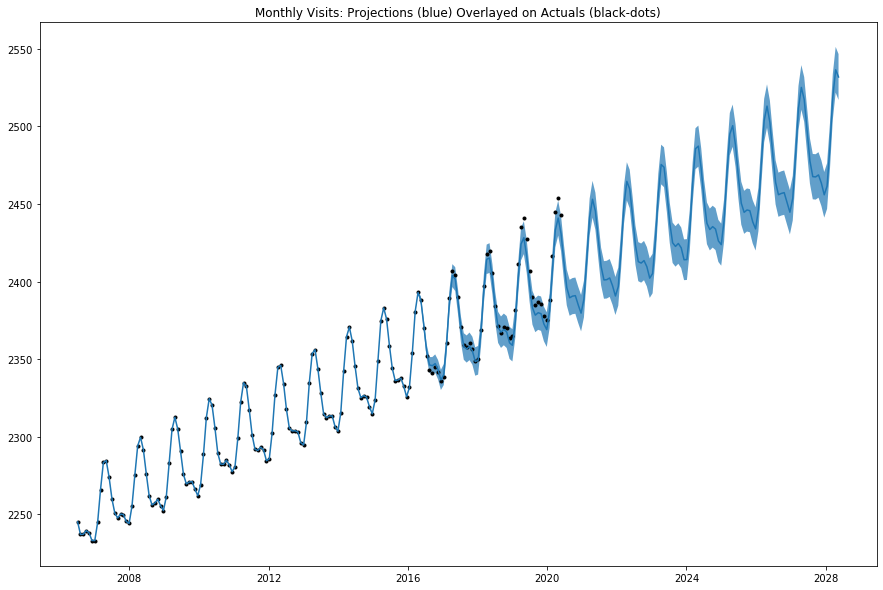

In [886]:
dates_before = dates[:-N_back]

M = 120
plt.figure(figsize=(15,10))
plt.plot(dates[-M-N_back:], y_orig[-M-N_back:], 'k.');
#plt.fill_between(dates_before[-M:], lower_est[-M:], upper_est[-M:], alpha=0.7);
plt.plot(dates_later, mu_pred_sc)
plt.fill_between(dates_later, lower_pred, upper_pred, alpha=0.7);
plt.title("Monthly Visits: Projections (blue) Overlayed on Actuals (black-dots)") 